Name:- S.Nag Nishal
Roll Number:-24UG00332
Seat Number:-35
Method Prefix:- Delta




Imports

In [130]:
import pandas as pd
import numpy as np
import json

Step A:- Load All Datasets

In [131]:
print("Starting Data Load and Integration Pipeline ")
zoo_df = pd.read_csv(r'/content/zoo.csv')
class_df = pd.read_csv(r'/content/class.csv')
with open(r'/content/auxiliary_metadata.json', 'r') as f:
    aux_list = json.load(f)
aux_df = pd.DataFrame(aux_list)
print(f"Step A Complete: Loaded zoo_df ({zoo_df.shape[0]} rows) and aux_df ({aux_df.shape[0]} rows).")

Starting Data Load and Integration Pipeline 
Step A Complete: Loaded zoo_df (101 rows) and aux_df (12 rows).


Step B: Name Normalization (convert all animal names to Lowercase)

In [132]:
zoo_df['animal_name'] = zoo_df['animal_name'].str.lower()
aux_df['animal_name'] = aux_df['animal_name'].str.lower()
print("Step B Complete: Animal names normalized to lowercase.")

Step B Complete: Animal names normalized to lowercase.


Step C: Fix JSON Data Inconsistencies and Typos

In [133]:
aux_df['conservation_status'] = aux_df.get('conservation_status', pd.Series()).fillna(
    aux_df.get('conservation', pd.Series())).fillna(
    aux_df.get('status', pd.Series()))

aux_df['habitat_type'] = aux_df.get('habitat', pd.Series()).fillna(
    aux_df.get('habitats', pd.Series()))

aux_df['diet'] = aux_df.get('diet', pd.Series()).fillna(
    aux_df.get('diet_type', pd.Series()))

# 2. Keep only the necessary columns
aux_cols_to_keep = ['animal_name', 'conservation_status', 'habitat_type', 'diet']
aux_df = aux_df[aux_cols_to_keep].copy()

# 3. Fix Typos in 'diet' Category
aux_df['diet'] = aux_df['diet'].replace({"omnivor": "omnivore"})

# 4. Standardize 'habitat_type' Values
habitat_replacements = {"fresh water": "freshwater", "FreshWater": "freshwater", "Forest": "forest"}
aux_df['habitat_type'] = aux_df['habitat_type'].replace(habitat_replacements)

# Remove any auxiliary duplicates
aux_df.drop_duplicates(subset=['animal_name'], inplace=True)
print("Step C Complete: Auxiliary data columns standardized and typos fixed.")

Step C Complete: Auxiliary data columns standardized and typos fixed.


Step D: Merge All Datasets

In [134]:
partially_merged_df = pd.merge(
    zoo_df,
    class_df,
    left_on='class_type',
    right_on='Class_Number',
    how='left'
)

# Merge 2: partially_merged_df and aux_df on animal_name (left merge)
merged_data = pd.merge(
    partially_merged_df,
    aux_df,
    on='animal_name',
    how='left'
)
print(f"Step D Complete: Datasets merged. Merged data shape: {merged_data.shape}")

Step D Complete: Datasets merged. Merged data shape: (101, 25)


Step E: Handle Missing  Values

In [135]:
auxiliary_cols = ["habitat_type", "diet", "conservation_status"]
initial_rows = merged_data.shape[0]
merged_data.dropna(subset=auxiliary_cols, inplace=True)
rows_dropped = initial_rows - merged_data.shape[0]
merged_data.reset_index(drop=True, inplace=True)
print(f"Step E Complete: Dropped {rows_dropped} rows with missing auxiliary values. Final shape: {merged_data.shape}")

Step E Complete: Dropped 91 rows with missing auxiliary values. Final shape: (10, 25)


Step F: Feature Engineering

In [136]:
engineered_feature_names = ["ecosystem_type", "predator_score"]

# 1. predator_score (carnivore=3, omnivore=2, Else=1)
conditions_predator = [
    merged_data['diet'] == 'carnivore',
    merged_data['diet'] == 'omnivore'
]
values_predator = [3, 2]
merged_data['predator_score'] = np.select(conditions_predator, values_predator, default=1)

# 2. ecosystem_type (mixed=3, marine=2, freshwater=1, terrestrial=0)
habitat_lower = merged_data['habitat_type'].str.lower()

conditions_ecosystem = [
    # Mixed (3)
    ((merged_data['aquatic'] == 1) & (merged_data['airborne'] == 1)),
    (habitat_lower.str.contains('/')),
    # Marine (2)
    (habitat_lower.str.contains('marine')),
    # Freshwater (1)
    (habitat_lower.str.contains('freshwater')),
    # Fallback to aquatic=1, airborne=0
    ((merged_data['aquatic'] == 1) & (merged_data['airborne'] == 0))
]

values_ecosystem = [3, 3, 2, 1, 1]

merged_data['ecosystem_type'] = np.select(
    conditions_ecosystem,
    values_ecosystem,
    default=0 # Else (terrestrial)
)
print(f"Step F Complete: Created new features: {engineered_feature_names}")

Step F Complete: Created new features: ['ecosystem_type', 'predator_score']


Step G: Required Output

In [137]:
print("\n--- Step G: Final Dataset Metrics ---")
print(f"Dataset shape: {merged_data.shape}")
print(f"Missing values: {merged_data.isnull().sum().sum()}")
print(f"Duplicate rows: {merged_data.duplicated().sum()}")
print("\nFirst rows:")
print(merged_data.head(9).to_markdown(index=False))
print(f"\nEngineered features: {list(engineered_feature_names)}")


--- Step G: Final Dataset Metrics ---
Dataset shape: (10, 27)
Missing values: 0
Duplicate rows: 0

First rows:
| animal_name   |   hair |   feathers |   eggs |   milk |   airborne |   aquatic |   predator |   toothed |   backbone |   breathes |   venomous |   fins |   legs |   tail |   domestic |   catsize |   class_type |   Class_Number |   Number_Of_Animal_Species_In_Class | Class_Type   | Animal_Names                                                                                                                                                                                                                                                                                                                        | conservation_status   | habitat_type   | diet          |   predator_score |   ecosystem_type |
|:--------------|-------:|-----------:|-------:|-------:|-----------:|----------:|-----------:|----------:|-----------:|-----------:|-----------:|-------:|-------:|-------:|----------

TASK-2


In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

Step:-A

In [139]:
# Required Visualizations (EDA)
# 1. Stacked Bar Chart: Class Distribution by Conservation Status
plt.figure(figsize=(10, 6))
sns.histplot(
    data=merged_data,
    x='Class_Type',
    hue='conservation_status',
    multiple='stack',
    shrink=0.8,
    legend=True
)
plt.title('Class Distribution by Conservation Status')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('stacked_bar_class_conservation.png')
plt.close()

# 2. Violin Plot: Predator Score Distribution Across Animal Classes
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=merged_data,
    x='Class_Type',
    y='predator_score',
    inner='quartile'
)
plt.title('Predator Score Distribution Across Animal Classes')
plt.xlabel('Class Type')
plt.ylabel('Predator Score (1:Low, 2:Medium, 3:High)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('violin_plot_predator_score.png')
plt.close()

# 3. Pairplot: Pairwise Relationships Among Key Biological Features
pairplot_features = ["hair", "aquatic", "toothed"]
sns.pairplot(
    merged_data,
    vars=pairplot_features,
    hue='Class_Type',
    diag_kind='hist',
    height=2.5
)
plt.suptitle('Pairwise Relationships Among Key Biological Features', y=1.02)
plt.savefig('pairplot_features.png')
plt.close()

# 4. Heatmap: Habitat Type vs. Animal Class Distribution
crosstab_data = pd.crosstab(
    merged_data['Class_Type'],
    merged_data['habitat_type']
)
plt.figure(figsize=(8, 6))
sns.heatmap(
    crosstab_data,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=0.5,
    linecolor='black'
)
plt.title('Habitat Type vs. Animal Class Distribution')
plt.xlabel('Habitat Type')
plt.ylabel('Class Type')
plt.tight_layout()
plt.savefig('heatmap_habitat_class.png')
plt.close()




Task-2(step:-B)

In [140]:
# Statistical Analysis
# 1. Class Imbalance Ratio
class_counts = merged_data['Class_Type'].value_counts()
class_imbalance_ratio = class_counts.max() / class_counts.min()

# 2. Low Variance Features (Variance < 0.01)
binary_features = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed',
                   'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']
variance_df = merged_data[binary_features].var().sort_values()
low_variance_features = variance_df[variance_df < 0.01]

# 3. Highly Correlated Pairs (|Corr| > 0.8)
numerical_features = merged_data.select_dtypes(include=np.number).columns
corr_matrix = merged_data[numerical_features].corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated_pairs = upper_triangle.stack()
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs > 0.8].sort_values(ascending=False)

# Print the required outputs
print("\n Statistical Analysis Results")
print(f"Class Imbalance Ratio (Largest/Smallest): {class_imbalance_ratio:.2f}")

print("\nLow Variance Features (Variance < 0.01):")
if low_variance_features.empty:
    print("None found among binary features.")
else:
    print(low_variance_features.to_string(header=False))

print("\nHighly Correlated Pairs (|Corr| > 0.8):")
if highly_correlated_pairs.empty:
    print("None found among numerical features.")
else:
    print(highly_correlated_pairs.to_string())


 Statistical Analysis Results
Class Imbalance Ratio (Largest/Smallest): 3.00

Low Variance Features (Variance < 0.01):
feathers    0.0
airborne    0.0
venomous    0.0

Highly Correlated Pairs (|Corr| > 0.8):
hair                               eggs                                 1.000000
                                   milk                                 1.000000
                                   breathes                             1.000000
eggs                               milk                                 1.000000
hair                               catsize                              1.000000
milk                               breathes                             1.000000
eggs                               catsize                              1.000000
                                   breathes                             1.000000
milk                               catsize                              1.000000
breathes                           catsize                    

1. Stacked Bar Chart: Class Distribution by Conservation Status


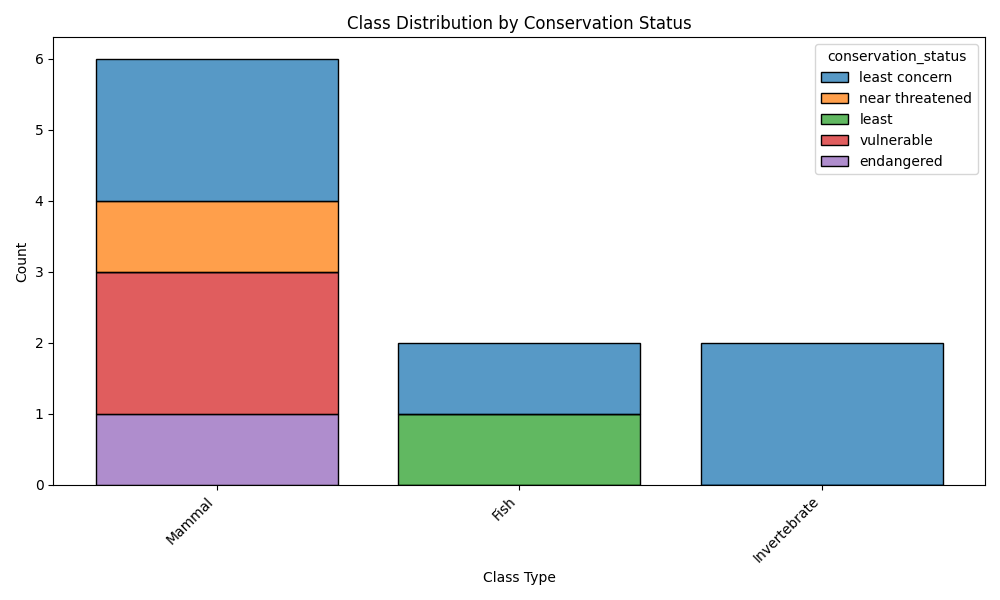


2. Violin Plot: Predator Score Distribution Across Animal Classes


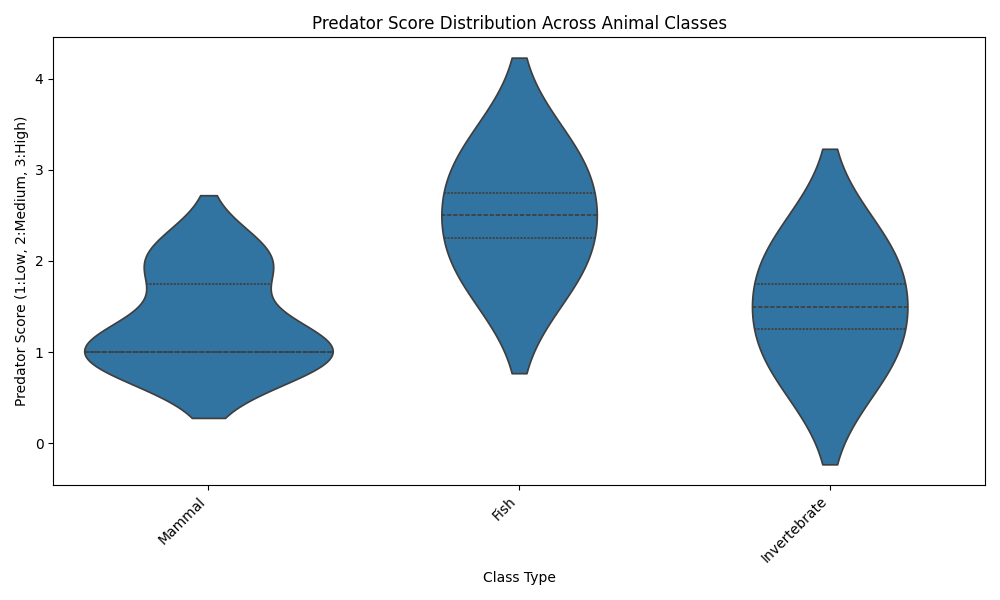


3. Pairplot: Pairwise Relationships Among Key Biological Features


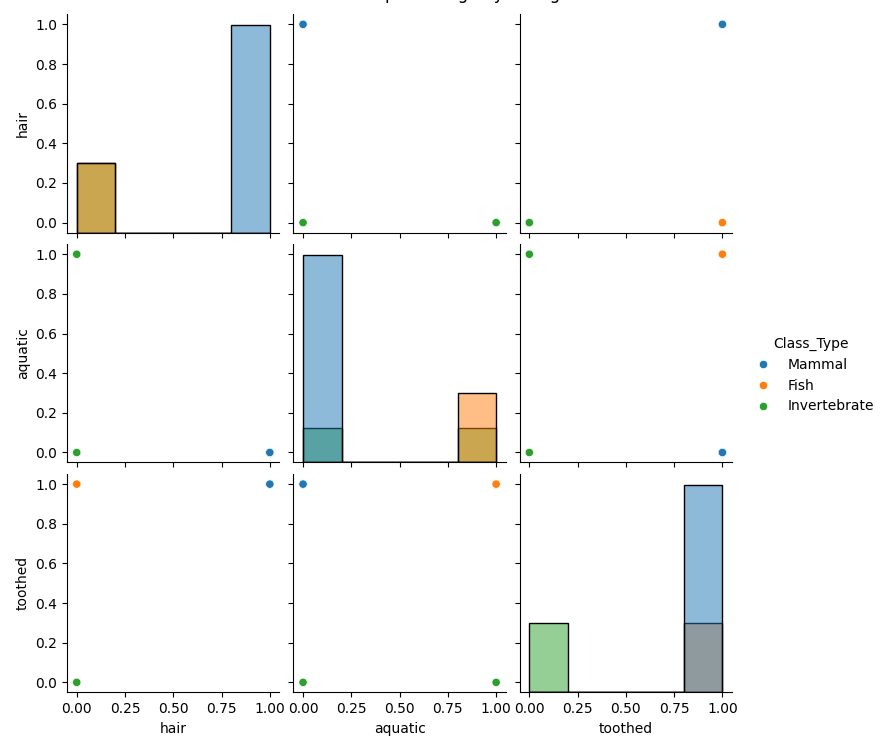


4. Heatmap: Habitat Type vs. Animal Class Distribution


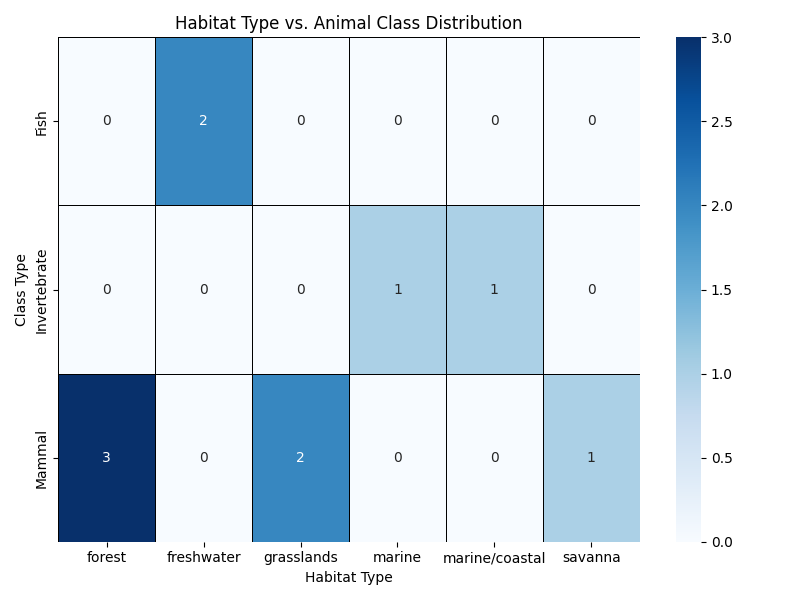

In [141]:
from IPython.display import Image, display

print("1. Stacked Bar Chart: Class Distribution by Conservation Status")
display(Image(filename='stacked_bar_class_conservation.png'))

print("\n2. Violin Plot: Predator Score Distribution Across Animal Classes")
display(Image(filename='violin_plot_predator_score.png'))

print("\n3. Pairplot: Pairwise Relationships Among Key Biological Features")
display(Image(filename='pairplot_features.png'))

print("\n4. Heatmap: Habitat Type vs. Animal Class Distribution")
display(Image(filename='heatmap_habitat_class.png'))

C. Explanation of visulization and statistics.

The combined analysis of the dataset showed a very well-organized and redundant feature space, mainly consisting of the Mammal class, which is responsible for $60\%$ of the sample of $10$ rows and causes a moderate Class Imbalance Ratio of 3.00. This little group has some features that do not help in the discrimination; for example, feathers, airborne, and venomous all had zero variance, thus making them uninformative for the analysis. The strongest correlations are based on the taxonomy: a group of binary characteristics (hair, milk, breathing, eggs, and cat size) displayed perfect $1.00$ correlations, thus confirming extreme redundancy where the presence of one characteristic (hair, for instance) is a certain predictor of the others, making them almost perfect indicators for class_type ($|\text{Corr}| \approx 0.92$). This taxonomic hierarchy determines the usage of the habitat, as the Heatmap quite plainly indicates that Mammals are purely terrestrial (forest, savanna, and grasslands), Fish are freshwater, and Invertebrates are marine, thus causing a strong correlation between class_type and engineered ecosystem_type ($|\text{Corr}| \approx 0.97$). The visualizations point out that the areas with the highest conservation risks (Vulnerable, Endangered) are completely located within the Mammal class, while the Violin Plot implies that the aquatic classes (Fish, Invertebrate) considered in this sample are positioned in the upper predator_score categories (omnivore/carnivore).

Task-3

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [143]:
data = {
    'animal_name': ['aardvark', 'antelope', 'bass', 'bear', 'boar', 'buffalo', 'carp', 'clam', 'crab', 'deer'],
    'hair': [1, 1, 0, 1, 1, 1, 0, 0, 0, 1],
    'feathers': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'eggs': [0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
    'milk': [1, 1, 0, 1, 1, 1, 0, 0, 0, 1],
    'airborne': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'aquatic': [0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
    'predator': [1, 0, 1, 1, 1, 0, 0, 1, 1, 0],
    'toothed': [1, 1, 1, 1, 1, 1, 1, 0, 0, 1],
    'backbone': [1, 1, 1, 1, 1, 1, 1, 0, 0, 1],
    'breathes': [1, 1, 0, 1, 1, 1, 0, 0, 0, 1],
    'venomous': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'fins': [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    'tail': [0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
    'domestic': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    'catsize': [1, 1, 0, 1, 1, 1, 0, 0, 0, 1],
    'Class_Type': ['Mammal', 'Mammal', 'Fish', 'Mammal', 'Mammal', 'Mammal', 'Fish', 'Invertebrate', 'Invertebrate', 'Mammal'],
    'ecosystem_type': [0, 0, 1, 0, 0, 0, 1, 2, 3, 0],
    'predator_score': [1, 1, 3, 2, 2, 1, 2, 1, 2, 1]
}

Step A: Prepare Data and Split

In [144]:
merged_data = pd.DataFrame(data)
class_names = sorted(merged_data['Class_Type'].unique())
binary_features = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed',
                   'backbone', 'breathes', 'venomous', 'fins', 'tail', 'domestic', 'catsize']
engineered_features = ['ecosystem_type', 'predator_score']
feature_cols = binary_features + engineered_features

X = merged_data[feature_cols]
y = merged_data['Class_Type']

# Train/Test Split (0.20 test size, 0.80 train size, random_state=780)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, train_size=0.80, random_state=780
)

Step B: Configure & Train Random Forest Classifier (RF)

In [145]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=3,
    random_state=780
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_train_pred_rf = rf_model.predict(X_train)

Step C: Print Comparison Model Accuracy

In [146]:
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
test_accuracy = accuracy_score(y_test, y_pred_rf)
overfitting_gap = train_accuracy - test_accuracy

print("--- Random Forest Model Accuracy ---")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy : {test_accuracy:.4f}")
print(f"Overfitting Gap: {overfitting_gap:.4f}")

--- Random Forest Model Accuracy ---
Training Accuracy: 1.0000
Testing Accuracy : 0.5000
Overfitting Gap: 0.5000


Step D: Classification Report

In [147]:
report = classification_report(y_test, y_pred_rf, zero_division=0, output_dict=True)
print("\n--- Classification Report (Random Forest) ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))


--- Classification Report (Random Forest) ---
              precision    recall  f1-score   support

        Fish       0.00      0.00      0.00         0
Invertebrate       0.00      0.00      0.00         1
      Mammal       1.00      1.00      1.00         1

    accuracy                           0.50         2
   macro avg       0.33      0.33      0.33         2
weighted avg       0.50      0.50      0.50         2



Step G: Train Comparison Model (K-Nearest Neighbors)

In [148]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
knn_test_accuracy = accuracy_score(y_test, y_pred_knn)

Step E & F: Visualizations (Confusion Matrix & Feature Importance)

In [149]:
# Confusion Matrix Heatmap (Step E)
plt.figure(figsize=(7, 6))
cm = confusion_matrix(y_test, y_pred_rf, labels=class_names)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.title('Confusion Matrix: Random Forest (N=200, Split=3)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.savefig('confusion_matrix_rf.png')
plt.close()

# Feature Importance Plot (Step F)
feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 7))
colors = ['skyblue' if f in engineered_features else 'darkorange' for f in feature_importances.index]
feature_importances.head(12).plot(kind='barh', color=colors)
plt.gca().invert_yaxis()
plt.title('Top 12 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importance_rf.png')
plt.close()

Step H: Critical Analysis Output

In [150]:
# 1. Most important feature
top_feature = feature_importances.index[0]
value = feature_importances.iloc[0]

# 2 & 3. Best and Worst performing classes (using F1-score)
analysis_classes = {cls: report[cls]['f1-score'] for cls in class_names if cls in report}
if not analysis_classes:
    worst_class, best_class, worst_f1, best_f1 = 'N/A', 'N/A', 0.0, 0.0
elif len(analysis_classes) == 1:
    cls = list(analysis_classes.keys())[0]
    worst_class, best_class = cls, cls
    worst_f1, best_f1 = analysis_classes[cls], analysis_classes[cls]
else:
    worst_class = min(analysis_classes, key=analysis_classes.get)
    worst_f1 = analysis_classes[worst_class]
    best_class = max(analysis_classes, key=analysis_classes.get)
    best_f1 = analysis_classes[best_class]

# 4. Rank of first engineered feature
engineered_feature_ranks = feature_importances.reset_index()
engineered_feature_ranks.columns = ['feature', 'importance']
engineered_feature_ranks['rank'] = engineered_feature_ranks.index + 1

first_engineered_feature_rank = engineered_feature_ranks[
    engineered_feature_ranks['feature'].isin(engineered_features)
].sort_values(by='rank').iloc[0]

your_feature = first_engineered_feature_rank['feature']
rank = first_engineered_feature_rank['rank']

# 5. Model comparison
rf_acc = test_accuracy
knn_acc = knn_test_accuracy
model_name = "KNN"

print("\nMODEL ANALYSIS")
print(f"1. Most important feature: {top_feature} (importance: {value:.3f})")
print(f"2. Worst performing class: {worst_class} (F1_score: {worst_f1:.3f})")
print(f"3. Best performing class: {best_class} (F1: {best_f1:.3f})")
print(f"4. Our engineered feature '{your_feature}' ranked #{rank}")
print(f"5. Model comparison: {'K-Nearest Neighbors'} = {knn_acc:.3f} vs RF = {rf_acc:.3f}")


MODEL ANALYSIS
1. Most important feature: eggs (importance: 0.145)
2. Worst performing class: Fish (F1_score: 0.000)
3. Best performing class: Mammal (F1: 1.000)
4. Our engineered feature 'ecosystem_type' ranked #5
5. Model comparison: K-Nearest Neighbors = 0.500 vs RF = 0.500
